## Wasserstein autoencoder

In [1]:
import apogee.tools.read as apread
import matplotlib.pyplot as plt 
import apogee.tools.path as apogee_path
from apogee.tools import bitmask

import random
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
from torch.autograd import Variable
import torch.autograd as autograd


from apoNN.src.datasets import ApogeeDataset,AspcapDataset
from apoNN.src.utils import get_mask_elem,dump,load,generate_loss_with_masking

import apoNN.src.vectors as vector


from tagging.src.networks import ConditioningAutoencoder,Embedding_Decoder,Feedforward,ParallelDecoder,Autoencoder,Discriminator

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
apogee_path.change_dr(16)


[(['TEFF', 'LOGG', 'LOG10VDOP', 'METALS', 'C', 'N', 'O Mg Si S Ca Ti'], ['C', 'N', 'O', 'Na', 'Mg', 'Al', 'Si', 'S', 'K', 'Ca', 'Ti', 'V', 'Mn', 'Fe', 'Ni'], ['[C/M]', '[N/M]', '[O/M]', '[Na/H]', '[Mg/M]', '[Al/H]', '[Si/M]', '[S/M]', '[K/H]', '[Ca/M]', '[Ti/M]', '[V/H]', '[Mn/H]', '[Fe/H]', '[Ni/H]'], [0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1])]


In [12]:
dataset_name = "aspcap_training_clean"
recenter=True
n_bins = 8575
n_z = 16
n_shared = 5
activation = nn.LeakyReLU()
lr = 0.0001
n_batch = 64
lambda_fact = 0.01
encoder_architecture = [n_bins,1024,512,128,n_z]
decoder_architecture = [n_z,128,512,1024,n_bins]

In [4]:
dataset = AspcapDataset(filename=dataset_name,recenter=recenter)
dataset_occam = AspcapDataset(filename="aspcap_occam",recenter=True,tensor_type=torch.FloatTensor)

In [5]:
loader = torch.utils.data.DataLoader(dataset = dataset,
                                     batch_size = n_batch,
                                     shuffle= True,
                                     drop_last=True)

In [6]:
encoder = Feedforward([n_bins,512,128,32,n_z],activation=nn.SELU()).to(device)
decoder = Feedforward([n_z,512,128,n_bins],activation=nn.SELU()).to(device)
autoencoder = Autoencoder(encoder,decoder,n_bins=n_bins).to(device)

discriminator = Feedforward([n_z,512,256,128,32,1],activation=nn.SELU()).to(device)



In [7]:
loss = nn.MSELoss()

lambda_gp = 10
n_critic = 10
optimizer_G = torch.optim.Adam(autoencoder.parameters(), lr=lr)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr)

Tensor = torch.FloatTensor



In [8]:

def compute_gradient_penalty(D, real_samples, fake_samples):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    alpha = Tensor(np.random.random((real_samples.size(0), 1)))
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = Variable(Tensor(real_samples.shape[0], 1).fill_(1.0), requires_grad=False)
    # Get gradient w.r.t. interpolates
    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty




In [51]:
batches_done = 0
for epoch in range(10000):
    for i, (x,u,v,idx) in enumerate(loader):
        optimizer_G.zero_grad()
        x_pred,z = autoencoder(x)
        real = z
        fake = torch.randn(z.shape)
        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Real images
        real_validity = discriminator(real)
        # Fake images
        fake_validity = discriminator(fake)
        # Gradient penalty
        gradient_penalty = compute_gradient_penalty(discriminator, real.data, fake.data)
        # Adversarial loss
        d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gradient_penalty

        d_loss.backward(retain_graph=True)
        optimizer_D.step()

        optimizer_G.zero_grad()

        # Train the generator every n_critic steps
        if i % n_critic == 0:

            # -----------------
            #  Train Generator
            # -----------------

            # Loss measures generator's ability to fool the discriminator
            # Train on fake images
            fake_validity = discriminator(fake)
            real_validity = discriminator(real)

            err_pred = loss(x_pred,x)

            g_loss = err_pred-lambda_fact*10*(torch.mean(fake_validity)-torch.mean(real_validity))


            g_loss.backward()
            optimizer_G.step()
            if i%30*n_critic ==0:
                print(
                    "[Epoch %d/%d] [Batch %d/%d] [D: %f] [G: %f] [R: %f]"
                    % (epoch, 100, i, len(loader), d_loss.item(), torch.mean(fake_validity).item(),err_pred.item())
                )


                batches_done += n_critic






[Epoch 0/100] [Batch 0/312] [D: -2.759662] [G: 22.521971] [R: 0.004683]
[Epoch 0/100] [Batch 30/312] [D: -2.822412] [G: 22.672064] [R: 0.005414]
[Epoch 0/100] [Batch 60/312] [D: -2.910625] [G: 22.594885] [R: 0.005227]
[Epoch 0/100] [Batch 90/312] [D: -2.537907] [G: 22.725121] [R: 0.003325]
[Epoch 0/100] [Batch 120/312] [D: -2.708971] [G: 22.738150] [R: 0.003593]
[Epoch 0/100] [Batch 150/312] [D: -2.911098] [G: 22.904018] [R: 0.004019]
[Epoch 0/100] [Batch 180/312] [D: -2.333395] [G: 23.335079] [R: 0.003971]
[Epoch 0/100] [Batch 210/312] [D: -2.454134] [G: 23.439220] [R: 0.005647]
[Epoch 0/100] [Batch 240/312] [D: -2.362751] [G: 23.858459] [R: 0.005163]
[Epoch 0/100] [Batch 270/312] [D: -2.454611] [G: 23.646284] [R: 0.005349]
[Epoch 0/100] [Batch 300/312] [D: -2.597310] [G: 23.421215] [R: 0.004245]
[Epoch 1/100] [Batch 0/312] [D: -2.396061] [G: 23.530632] [R: 0.003556]
[Epoch 1/100] [Batch 30/312] [D: -2.736678] [G: 23.075911] [R: 0.003274]
[Epoch 1/100] [Batch 60/312] [D: -2.402728] [G

[Epoch 10/100] [Batch 60/312] [D: -2.315536] [G: 24.650448] [R: 0.000868]
[Epoch 10/100] [Batch 90/312] [D: -2.561962] [G: 24.582718] [R: 0.000964]
[Epoch 10/100] [Batch 120/312] [D: -2.482115] [G: 24.680870] [R: 0.000806]
[Epoch 10/100] [Batch 150/312] [D: -2.390168] [G: 24.708462] [R: 0.001008]
[Epoch 10/100] [Batch 180/312] [D: -2.503092] [G: 24.236794] [R: 0.000868]
[Epoch 10/100] [Batch 210/312] [D: -2.263767] [G: 24.545677] [R: 0.000918]
[Epoch 10/100] [Batch 240/312] [D: -2.380030] [G: 24.504097] [R: 0.000865]
[Epoch 10/100] [Batch 270/312] [D: -2.175001] [G: 24.648510] [R: 0.001379]
[Epoch 10/100] [Batch 300/312] [D: -2.193748] [G: 24.694887] [R: 0.000990]
[Epoch 11/100] [Batch 0/312] [D: -2.379736] [G: 24.625546] [R: 0.001109]
[Epoch 11/100] [Batch 30/312] [D: -2.587322] [G: 24.050076] [R: 0.000997]
[Epoch 11/100] [Batch 60/312] [D: -2.359738] [G: 24.123186] [R: 0.001065]
[Epoch 11/100] [Batch 90/312] [D: -2.514921] [G: 23.545328] [R: 0.000963]
[Epoch 11/100] [Batch 120/312] [

[Epoch 20/100] [Batch 60/312] [D: -2.088685] [G: 23.359585] [R: 0.000602]
[Epoch 20/100] [Batch 90/312] [D: -1.921570] [G: 23.695976] [R: 0.000663]
[Epoch 20/100] [Batch 120/312] [D: -2.097611] [G: 23.480284] [R: 0.000649]
[Epoch 20/100] [Batch 150/312] [D: -1.897034] [G: 23.700644] [R: 0.000622]
[Epoch 20/100] [Batch 180/312] [D: -1.801684] [G: 23.479607] [R: 0.000567]
[Epoch 20/100] [Batch 210/312] [D: -1.973383] [G: 23.289009] [R: 0.000640]
[Epoch 20/100] [Batch 240/312] [D: -1.962484] [G: 23.388706] [R: 0.000591]
[Epoch 20/100] [Batch 270/312] [D: -1.888917] [G: 23.522612] [R: 0.000535]
[Epoch 20/100] [Batch 300/312] [D: -1.988287] [G: 23.309553] [R: 0.000550]
[Epoch 21/100] [Batch 0/312] [D: -1.985304] [G: 23.358320] [R: 0.000641]
[Epoch 21/100] [Batch 30/312] [D: -1.878640] [G: 23.376392] [R: 0.000569]
[Epoch 21/100] [Batch 60/312] [D: -2.174817] [G: 23.062967] [R: 0.000547]
[Epoch 21/100] [Batch 90/312] [D: -2.047591] [G: 23.224112] [R: 0.000534]
[Epoch 21/100] [Batch 120/312] [

[Epoch 30/100] [Batch 60/312] [D: -1.373586] [G: 20.984694] [R: 0.000638]
[Epoch 30/100] [Batch 90/312] [D: -1.675427] [G: 20.980112] [R: 0.000549]
[Epoch 30/100] [Batch 120/312] [D: -1.639979] [G: 21.149597] [R: 0.000590]
[Epoch 30/100] [Batch 150/312] [D: -1.563017] [G: 21.466221] [R: 0.000611]
[Epoch 30/100] [Batch 180/312] [D: -1.718725] [G: 21.314804] [R: 0.000565]
[Epoch 30/100] [Batch 210/312] [D: -1.348567] [G: 21.242332] [R: 0.000619]
[Epoch 30/100] [Batch 240/312] [D: -1.530615] [G: 21.088486] [R: 0.000634]
[Epoch 30/100] [Batch 270/312] [D: -1.544370] [G: 21.059452] [R: 0.000589]
[Epoch 30/100] [Batch 300/312] [D: -1.447633] [G: 21.146099] [R: 0.000618]
[Epoch 31/100] [Batch 0/312] [D: -1.521239] [G: 21.080671] [R: 0.000607]
[Epoch 31/100] [Batch 30/312] [D: -1.275947] [G: 20.960796] [R: 0.000584]


KeyboardInterrupt: 

(array([0.12690074, 0.2220763 , 0.15862593, 0.28552667, 0.34897704,
        0.41242741, 0.28552667, 0.09517556, 0.06345039, 0.03172518]),
 array([-2.3181472 , -1.8256363 , -1.3331254 , -0.84061444, -0.34810352,
         0.14440739,  0.6369183 ,  1.1294292 ,  1.6219401 ,  2.114451  ,
         2.606962  ], dtype=float32),
 <a list of 10 Patch objects>)

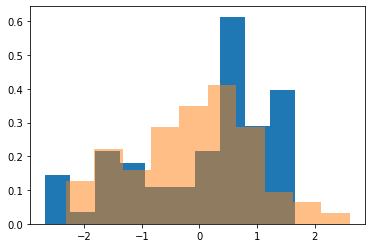

In [50]:
plt.hist(real[:,5].detach(),density=True)
plt.hist(fake[:,5].detach(),alpha=0.5,density=True)

(array([0.02911856, 0.02911854, 0.05823711, 0.2329484 , 0.43677825,
        0.2329484 , 0.4076597 , 0.26206698, 0.14559275, 0.02911855]),
 array([-3.0539224 , -2.517323  , -1.9807234 , -1.444124  , -0.90752447,
        -0.37092495,  0.16567454,  0.702274  ,  1.2388735 ,  1.775473  ,
         2.3120725 ], dtype=float32),
 <a list of 10 Patch objects>)

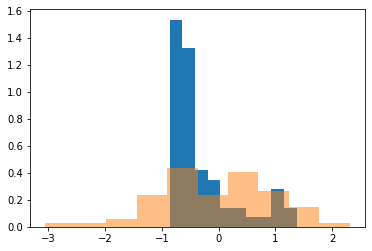

In [22]:
plt.hist(real[:,6].detach(),density=True)
plt.hist(fake[:,3].detach(),alpha=0.5,density=True)

(array([0.01253941, 0.0532925 , 0.16771465, 0.27586706, 0.34640125,
        0.38558691, 0.23981625, 0.09091074, 0.02664625, 0.00626971]),
 array([-2.9861386, -2.363103 , -1.7400674, -1.1170318, -0.4939962,
         0.1290394,  0.752075 ,  1.3751106,  1.9981462,  2.6211817,
         3.2442174], dtype=float32),
 <a list of 10 Patch objects>)

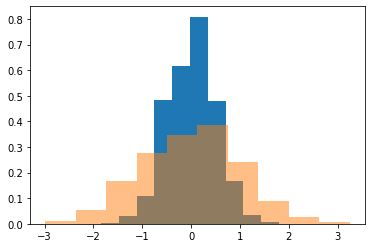

In [39]:
plt.hist(real[:].detach().flatten(),density=True)
plt.hist(fake[:].detach().flatten(),alpha=0.5,density=True)